# Jupyter Notebook 2: Optimizing (Under/Overfitting) 
### Based on Tensorflow Documentation

## Import
This import will using "tfdocs" for a little bit of plotting. You can install this with the block below....

In [9]:
import os
tf='tensorflow_docs'
try:
    import tensorflow_docs
    print("module",tf," is installed")
except ModuleNotFoundError:
    print("module ",tf," is not installed")
    os.system('pip install git+https://github.com/tensorflow/docs')


module tensorflow_docs  is installed


In [10]:
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import regularizers
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots
from  IPython import display
from matplotlib import pyplot as plt

import numpy as np

import pathlib
import shutil
import tempfile
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

## The Higgs Dataset
* Data set of higgs sims from: https://arxiv.org/pdf/1402.4735.pdf 
* These are a set of momentum measurements for particles of a set decay channel. 
* The exact details are not tremendously important sufficen to say there is a background and a signal and both have been labeled in the simulation stage
* We can plot some of these features below (they have been mostly normalized)

In [11]:
gz = tf.keras.utils.get_file('HIGGS.csv.gz', 'http://mlphysics.ics.uci.edu/data/higgs/HIGGS.csv.gz')

In [12]:
FEATURES = 28

ds = tf.data.experimental.CsvDataset(gz,[float(),]*(FEATURES+1), compression_type="GZIP")

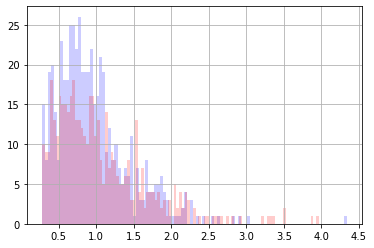

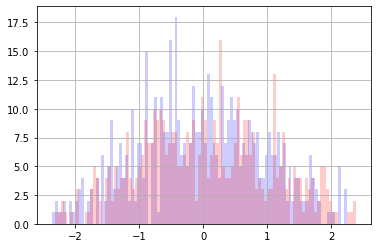

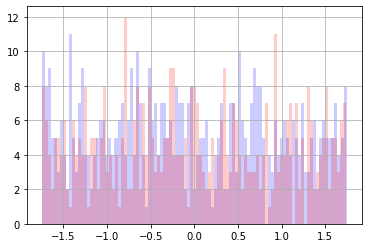

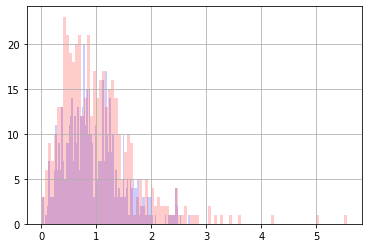

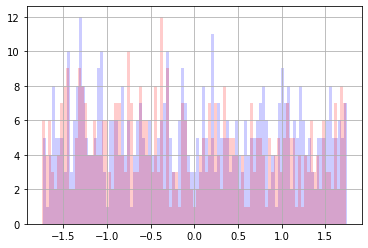

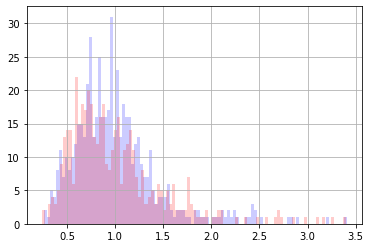

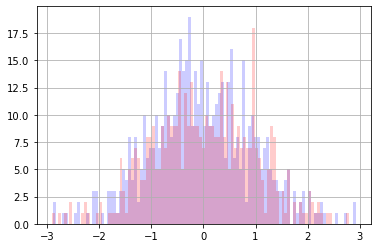

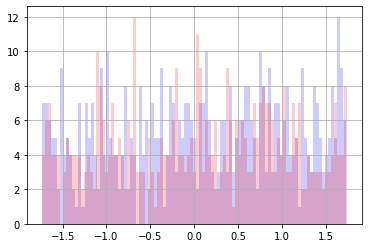

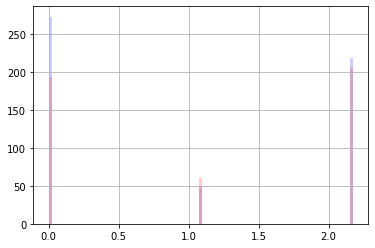

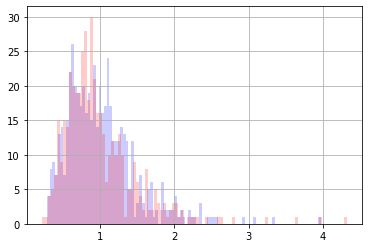

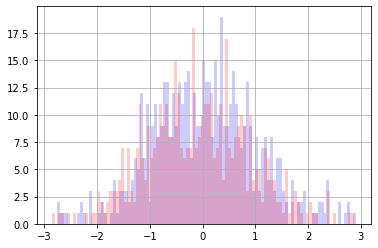

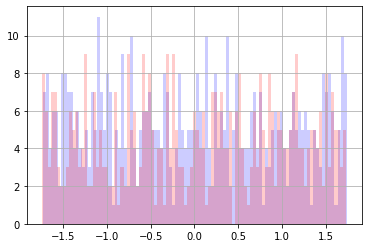

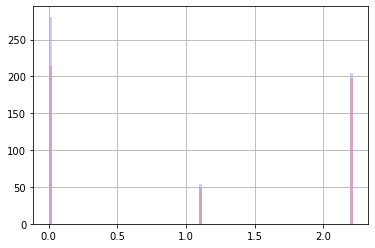

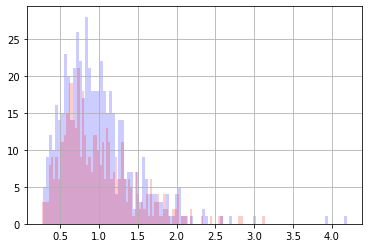

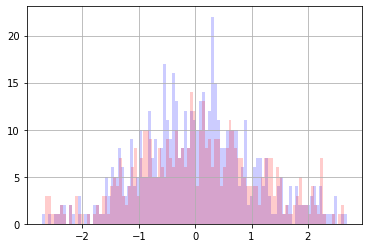

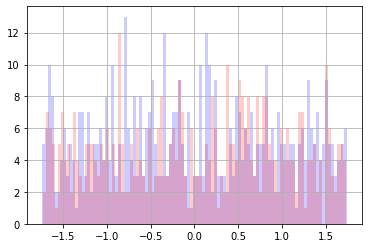

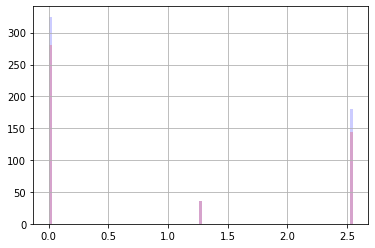

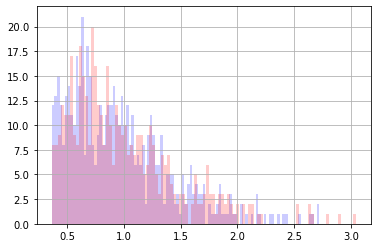

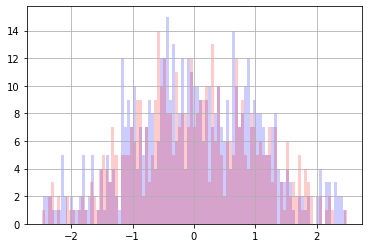

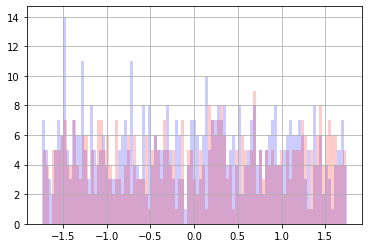

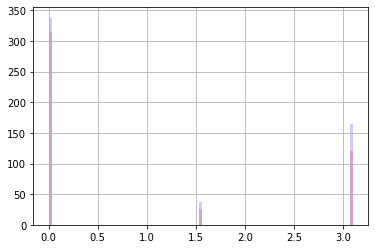

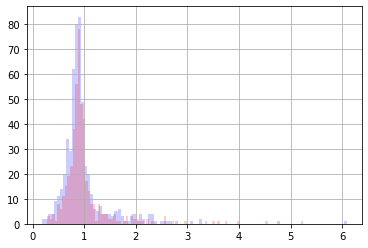

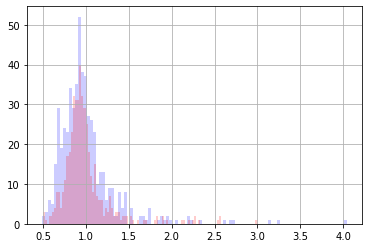

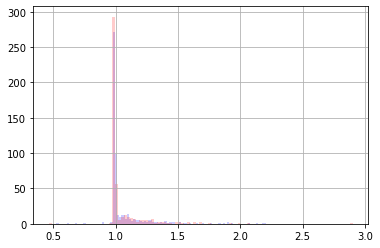

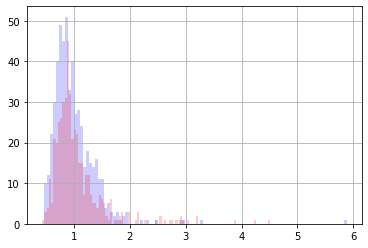

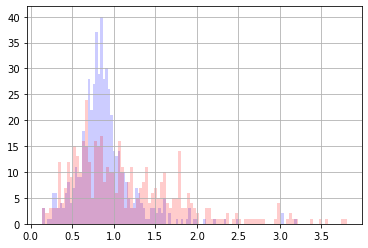

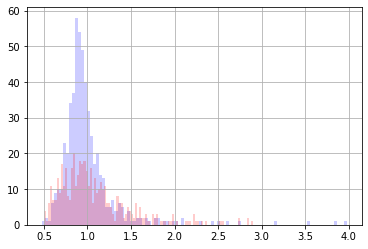

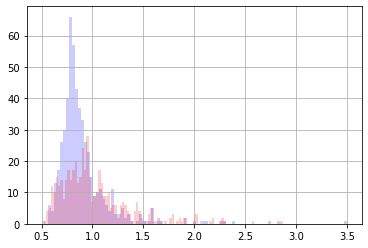

In [13]:
def pack_row(*row):
  label = row[0]
  features = tf.stack(row[1:],1)
  return features, label

packed_ds = ds.batch(10000).map(pack_row).unbatch()
for features,label in packed_ds.batch(1000).take(1):
    for i in range(FEATURES):
        plt.hist(features.numpy()[label.numpy().astype(bool),i].flatten(), bins = 101,color='blue',alpha=0.2)
        plt.hist(features.numpy()[~label.numpy().astype(bool),i].flatten(), bins = 101,color='red',alpha=0.2)
        plt.grid()
        plt.show()



## Sorting the Data
* This data did not come in folder instead it came as a large csv, so we need to select the label and feature names. We also will use a smaller subset. 

In [8]:

N_VALIDATION = int(1e3)
N_TRAIN = int(1e4)
BUFFER_SIZE = int(1e5)
BATCH_SIZE = 500
STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE

validate_ds = packed_ds.take(N_VALIDATION).cache()
train_ds = packed_ds.skip(N_VALIDATION).take(N_TRAIN).cache()


validate_ds = validate_ds.batch(BATCH_SIZE)
train_ds = train_ds.shuffle(BUFFER_SIZE).repeat().batch(BATCH_SIZE)

## Training procedure
* In gradient descent we saw that shrinking the step per epoch could improve the fitting. This is done with the scheduler.
* I haven't seen others using non-scheduled dependent gradient descent. If anybody has any examples of alternative schedulers I would love to talk about them. 

In [7]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=STEPS_PER_EPOCH*1000,
  decay_rate=1,
  staircase=False)

def get_optimizer():
  return tf.keras.optimizers.Adam(lr_schedule)

## Training and Fitting
* We will merge fitting and compiling in the same function. There are several options that we set prior to fitting to improve the visuals.
* We will use cross entropy and the adam optimizer https://arxiv.org/pdf/1412.6980.pdf

In [8]:
def get_callbacks(name):
  return [
    tfdocs.modeling.EpochDots(), #progress report
    tf.keras.callbacks.EarlyStopping(monitor='val_binary_crossentropy', patience=200), #stop when not changing
    tf.keras.callbacks.TensorBoard(logdir/name), #some display functionaility
  ]

In [9]:
def compile_and_fit(model, name, optimizer=None, max_epochs=10000):
  if optimizer is None:
    optimizer = get_optimizer()
  model.compile(optimizer=optimizer,
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=[
                  tf.keras.losses.BinaryCrossentropy(
                      from_logits=True, name='binary_crossentropy'),
                  'accuracy'])

  model.summary()

  history = model.fit(
    train_ds,
    steps_per_epoch = STEPS_PER_EPOCH,
    epochs=max_epochs,
    validation_data=validate_ds,
    callbacks=get_callbacks(name),
    verbose=0)
  return history

### Tiny model
* We can set up different models of incresing complexity in order to model the data. This just needs to be a series of dense layers as the data is already properly formated. 
* Our idea is basically here we will start with a very simple neural network and increase the number of layers. 
* All of these will have the same activation function and will take input from our features. 
* We will then plot the validation and training Binary cross entropy (loss) over time. 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                464       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 481
Trainable params: 481
Non-trainable params: 0
_________________________________________________________________


2021-11-22 19:19:18.621902: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-11-22 19:19:18.621934: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-11-22 19:19:18.622177: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


2021-11-22 19:19:20.108288: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-11-22 19:19:20.108332: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-11-22 19:19:20.113117: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-11-22 19:19:20.120921: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-11-22 19:19:20.131001: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: /tmp/tmpn_2l9s5v/tensorboard_logs/sizes/Tiny/train/plugins/profile/2021_11_22_19_19_20

2021-11-22 19:19:20.137531: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to /tmp/tmpn_2l9s5v/tensorboard_logs/sizes/Tiny/train/plugins/profile/2021_11_22_19_19_20/ubuntu.trace.json.gz
2021-11-22 19:19:20.141758: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: /tm


Epoch: 0, accuracy:0.4887,  binary_crossentropy:0.8185,  loss:0.8185,  val_accuracy:0.5040,  val_binary_crossentropy:0.7573,  val_loss:0.7573,  
....................................................................................................
Epoch: 100, accuracy:0.5952,  binary_crossentropy:0.6269,  loss:0.6269,  val_accuracy:0.6150,  val_binary_crossentropy:0.6258,  val_loss:0.6258,  
....................................................................................................
Epoch: 200, accuracy:0.6241,  binary_crossentropy:0.6128,  loss:0.6128,  val_accuracy:0.6010,  val_binary_crossentropy:0.6157,  val_loss:0.6157,  
...............................................................

2021-11-22 19:19:40.305782: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-11-22 19:19:40.378697: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


.....................................
Epoch: 300, accuracy:0.6429,  binary_crossentropy:0.6008,  loss:0.6008,  val_accuracy:0.6260,  val_binary_crossentropy:0.6032,  val_loss:0.6032,  
..............................................

2021-11-22 19:19:46.540755: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-11-22 19:19:46.721612: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


...

2021-11-22 19:19:46.878701: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-11-22 19:19:47.005416: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


..............

2021-11-22 19:19:48.062679: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-11-22 19:19:48.170686: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


.....................................
Epoch: 400, accuracy:0.6571,  binary_crossentropy:0.5934,  loss:0.5934,  val_accuracy:0.6530,  val_binary_crossentropy:0.5979,  val_loss:0.5979,  
................................................................................

2021-11-22 19:19:56.743969: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


....................
Epoch: 500, accuracy:0.6603,  binary_crossentropy:0.5894,  loss:0.5894,  val_accuracy:0.6330,  val_binary_crossentropy:0.5965,  val_loss:0.5965,  
.....

2021-11-22 19:19:58.606289: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


...........................................................

2021-11-22 19:20:02.994767: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


....................................
Epoch: 600, accuracy:0.6696,  binary_crossentropy:0.5860,  loss:0.5860,  val_accuracy:0.6430,  val_binary_crossentropy:0.5955,  val_loss:0.5955,  
....................................................................................................
Epoch: 700, accuracy:0.6695,  binary_crossentropy:0.5841,  loss:0.5841,  val_accuracy:0.6550,  val_binary_crossentropy:0.5944,  val_loss:0.5944,  
....................................................................................................
Epoch: 800, accuracy:0.6718,  binary_crossentropy:0.5821,  loss:0.5821,  val_accuracy:0.6550,  val_binary_crossentropy:0.5958,  val_loss:0.5958,  
....................................................................................................
Epoch: 900, accuracy:0.6744,  binary_crossentropy:0.5803,  loss:0.5803,  val_accuracy:0.6480,  val_binary_crossentropy:0.5967,  val_loss:0.5967,  
...............................................

(0.5, 0.7)

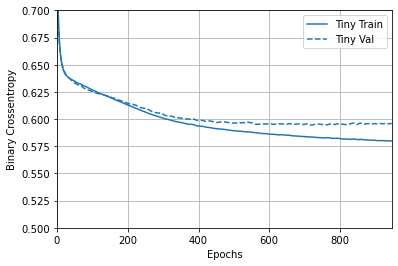

In [10]:
tiny_model = tf.keras.Sequential([
    layers.Dense(16, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(1)
])
size_histories = {}
size_histories['Tiny'] = compile_and_fit(tiny_model, 'sizes/Tiny')
plotter = tfdocs.plots.HistoryPlotter(metric = 'binary_crossentropy', smoothing_std=10)
plotter.plot(size_histories)
plt.ylim([0.5, 0.7])

### Small model

In [11]:
small_model = tf.keras.Sequential([
    # `input_shape` is only required here so that `.summary` works.
    layers.Dense(16, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(16, activation='elu'),
    layers.Dense(1)
])
size_histories['Small'] = compile_and_fit(small_model, 'sizes/Small')


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 16)                464       
_________________________________________________________________
dense_3 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 17        
Total params: 753
Trainable params: 753
Non-trainable params: 0
_________________________________________________________________


2021-11-22 19:20:31.707688: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-11-22 19:20:31.707716: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-11-22 19:20:31.708977: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.



Epoch: 0, accuracy:0.4995,  binary_crossentropy:0.7525,  loss:0.7525,  val_accuracy:0.4570,  val_binary_crossentropy:0.7318,  val_loss:0.7318,  
.

2021-11-22 19:20:32.089026: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-11-22 19:20:32.089053: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-11-22 19:20:32.106294: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-11-22 19:20:32.112240: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-11-22 19:20:32.119532: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: /tmp/tmpn_2l9s5v/tensorboard_logs/sizes/Small/train/plugins/profile/2021_11_22_19_20_32

2021-11-22 19:20:32.124577: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to /tmp/tmpn_2l9s5v/tensorboard_logs/sizes/Small/train/plugins/profile/2021_11_22_19_20_32/ubuntu.trace.json.gz
2021-11-22 19:20:32.126941: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: /

...................................................................................................
Epoch: 100, accuracy:0.6360,  binary_crossentropy:0.6027,  loss:0.6027,  val_accuracy:0.6460,  val_binary_crossentropy:0.5972,  val_loss:0.5972,  
....................................................................................................
Epoch: 200, accuracy:0.6718,  binary_crossentropy:0.5804,  loss:0.5804,  val_accuracy:0.6580,  val_binary_crossentropy:0.5838,  val_loss:0.5838,  
.............................

2021-11-22 19:20:48.293083: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


........................................

2021-11-22 19:20:51.103742: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


...............................
Epoch: 300, accuracy:0.6815,  binary_crossentropy:0.5720,  loss:0.5720,  val_accuracy:0.6550,  val_binary_crossentropy:0.5840,  val_loss:0.5840,  
............

2021-11-22 19:20:54.215876: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


........................................................................................
Epoch: 400, accuracy:0.6893,  binary_crossentropy:0.5657,  loss:0.5657,  val_accuracy:0.6530,  val_binary_crossentropy:0.5888,  val_loss:0.5888,  
............

### Medium model

In [12]:
medium_model = tf.keras.Sequential([
    layers.Dense(64, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(64, activation='elu'),
    layers.Dense(64, activation='elu'),
    layers.Dense(1)
])
size_histories['Medium']  = compile_and_fit(medium_model, "sizes/Medium")

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 64)                1856      
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_7 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total params: 10,241
Trainable params: 10,241
Non-trainable params: 0
_________________________________________________________________


2021-11-22 19:21:01.775350: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-11-22 19:21:01.775380: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-11-22 19:21:01.775660: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.



Epoch: 0, accuracy:0.4994,  binary_crossentropy:0.6908,  loss:0.6908,  val_accuracy:0.4950,  val_binary_crossentropy:0.6781,  val_loss:0.6781,  
.

2021-11-22 19:21:02.194326: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-11-22 19:21:02.194352: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-11-22 19:21:02.207628: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-11-22 19:21:02.211870: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-11-22 19:21:02.219193: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: /tmp/tmpn_2l9s5v/tensorboard_logs/sizes/Medium/train/plugins/profile/2021_11_22_19_21_02

2021-11-22 19:21:02.224254: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to /tmp/tmpn_2l9s5v/tensorboard_logs/sizes/Medium/train/plugins/profile/2021_11_22_19_21_02/ubuntu.trace.json.gz
2021-11-22 19:21:02.227321: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory:

...................................................................................................
Epoch: 100, accuracy:0.7155,  binary_crossentropy:0.5294,  loss:0.5294,  val_accuracy:0.6660,  val_binary_crossentropy:0.6017,  val_loss:0.6017,  
....................................................................................................
Epoch: 200, accuracy:0.7858,  binary_crossentropy:0.4316,  loss:0.4316,  val_accuracy:0.6300,  val_binary_crossentropy:0.6948,  val_loss:0.6948,  
...............................................................

### Large model


In [13]:
large_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(512, activation='elu'),
    layers.Dense(512, activation='elu'),
    layers.Dense(512, activation='elu'),
    layers.Dense(1)
])
size_histories['large'] = compile_and_fit(large_model, "sizes/large")

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 512)               14848     
_________________________________________________________________
dense_10 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_11 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_12 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 513       
Total params: 803,329
Trainable params: 803,329
Non-trainable params: 0
_________________________________________________________________


2021-11-22 19:21:26.076665: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-11-22 19:21:26.076692: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-11-22 19:21:26.078032: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-11-22 19:21:26.549706: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-11-22 19:21:26.549732: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-11-22 19:21:26.596654: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-11-22 19:21:26.601068: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-11-22 19:21:26.608161: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: /tmp/tmpn_2l9s5v/tensorboard_logs/sizes/large/train/plugins/profile/2021_11_22_19_21_26

2021-11-22 19


Epoch: 0, accuracy:0.5017,  binary_crossentropy:0.8128,  loss:0.8128,  val_accuracy:0.5560,  val_binary_crossentropy:0.6889,  val_loss:0.6889,  
....................................................................................................
Epoch: 100, accuracy:1.0000,  binary_crossentropy:0.0022,  loss:0.0022,  val_accuracy:0.6480,  val_binary_crossentropy:1.8276,  val_loss:1.8276,  
....................................................................................................
Epoch: 200, accuracy:1.0000,  binary_crossentropy:0.0002,  loss:0.0002,  val_accuracy:0.6450,  val_binary_crossentropy:2.4626,  val_loss:2.4626,  
......................

### Plot the training and validation losses
* What's going on in this plot?

Text(0.5, 0, 'Epochs [Log Scale]')

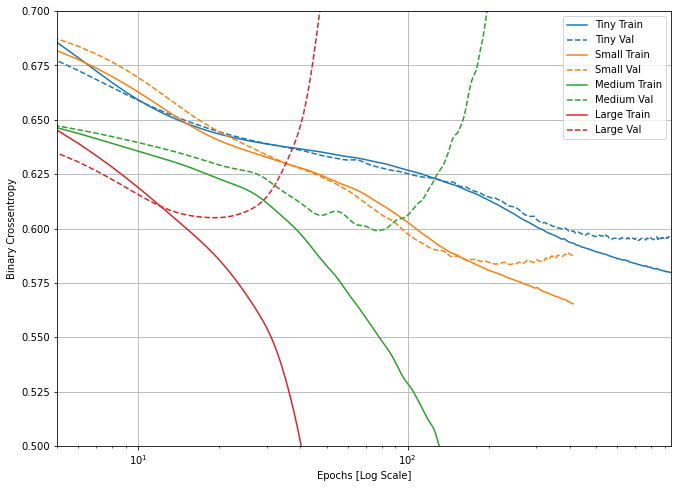

In [14]:
plt.figure(figsize=(11,8))
plotter.plot(size_histories)
a = plt.xscale('log')
plt.xlim([5, max(plt.xlim())])
plt.ylim([0.5, 0.7])
plt.xlabel("Epochs [Log Scale]")


## Strategies to prevent overfitting

* We will compare everything to the simple model. So let's save that. 
* We can try two things weight regularization, and dropout.

In [15]:
shutil.rmtree(logdir/'regularizers/Tiny', ignore_errors=True)
shutil.copytree(logdir/'sizes/Tiny', logdir/'regularizers/Tiny')

PosixPath('/tmp/tmpn_2l9s5v/tensorboard_logs/regularizers/Tiny')

In [16]:
regularizer_histories = {}
regularizer_histories['Tiny'] = size_histories['Tiny']

## Weights
* L2 or L1? These are penalties to the weights based on how large the weights are (large weights normally mean overfitting) 
* We can penalized based on the absolute value or the square of the value. 
* L1 -> loss = l1 * reduce_sum(abs(x)) : Laso Regression
* L2 -> loss = l2 * reduce_sum(square(x)) : Ridge Regression


In [17]:
l2_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001),
                 input_shape=(FEATURES,)),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(1)
])

regularizer_histories['l2'] = compile_and_fit(l2_model, "regularizers/l2")

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 512)               14848     
_________________________________________________________________
dense_15 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_16 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_17 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 513       
Total params: 803,329
Trainable params: 803,329
Non-trainable params: 0
_________________________________________________________________


2021-11-22 19:23:14.663362: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-11-22 19:23:14.663411: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-11-22 19:23:14.664110: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-11-22 19:23:15.298888: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-11-22 19:23:15.298919: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-11-22 19:23:15.356985: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-11-22 19:23:15.362543: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-11-22 19:23:15.372850: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: /tmp/tmpn_2l9s5v/tensorboard_logs/regularizers/l2/train/plugins/profile/2021_11_22_19_23_15

2021-11-2


Epoch: 0, accuracy:0.4991,  binary_crossentropy:0.7742,  loss:2.2702,  val_accuracy:0.5060,  val_binary_crossentropy:0.6754,  val_loss:2.0844,  
....................................................................................................
Epoch: 100, accuracy:0.6571,  binary_crossentropy:0.5941,  loss:0.6172,  val_accuracy:0.6730,  val_binary_crossentropy:0.5904,  val_loss:0.6135,  
....................................................................................................
Epoch: 200, accuracy:0.6753,  binary_crossentropy:0.5831,  loss:0.6054,  val_accuracy:0.6490,  val_binary_crossentropy:0.5840,  val_loss:0.6065,  
....................................................................................................
Epoch: 300, accuracy:0.6788,  binary_crossentropy:0.5749,  loss:0.5976,  val_accuracy:0.6560,  val_binary_crossentropy:0.5797,  val_loss:0.6025,  
....................................................................................................
Epoch: 40

(0.5, 0.7)

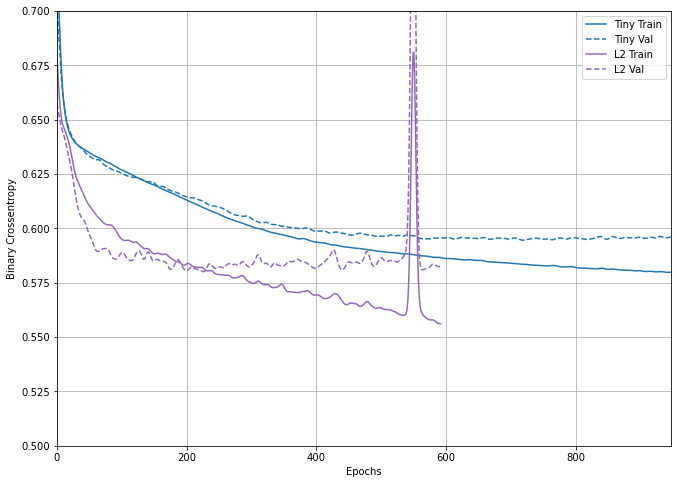

In [18]:
plt.figure(figsize=(11,8))
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

## Dropout
* Now recall that dropout is very effective way of removing overfitting
* Developed in Canada! 
* Usually 0.2 -> 0.5 (fraction of total features set to zero) 

In [19]:
dropout_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu', input_shape=(FEATURES,)),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(1)
])

regularizer_histories['dropout'] = compile_and_fit(dropout_model, "regularizers/dropout")

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 512)               14848     
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 512)              

2021-11-22 19:28:28.162867: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-11-22 19:28:28.162894: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-11-22 19:28:28.163033: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-11-22 19:28:28.702006: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-11-22 19:28:28.702032: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-11-22 19:28:28.751466: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-11-22 19:28:28.755622: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-11-22 19:28:28.763221: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: /tmp/tmpn_2l9s5v/tensorboard_logs/regularizers/dropout/train/plugins/profile/2021_11_22_19_28_28

2021


Epoch: 0, accuracy:0.5015,  binary_crossentropy:0.7932,  loss:0.7932,  val_accuracy:0.5530,  val_binary_crossentropy:0.6785,  val_loss:0.6785,  
....................................................................................................
Epoch: 100, accuracy:0.6622,  binary_crossentropy:0.5958,  loss:0.5958,  val_accuracy:0.6690,  val_binary_crossentropy:0.5730,  val_loss:0.5730,  
....................................................................................................
Epoch: 200, accuracy:0.6887,  binary_crossentropy:0.5570,  loss:0.5570,  val_accuracy:0.6940,  val_binary_crossentropy:0.5761,  val_loss:0.5761,  
...................................................................................................

(0.5, 0.7)

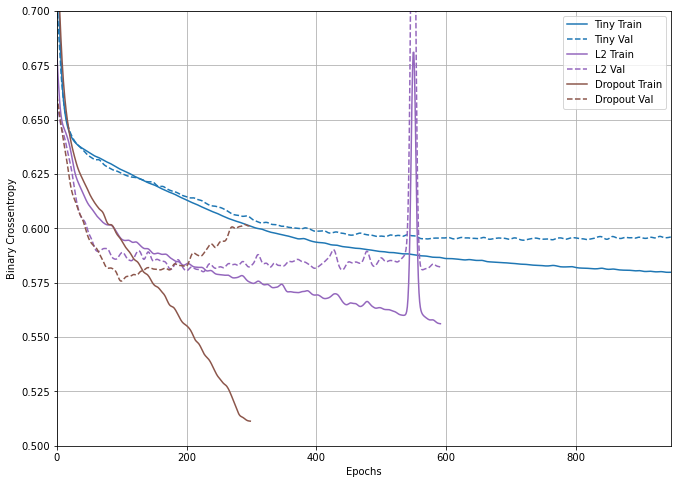

In [20]:
plt.figure(figsize=(11,8))
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

## Combining L2 + dropout
* Now let's put it all together and we will lower the power of the L2 regularization. 

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 512)               14848     
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 512)              

2021-11-22 19:31:56.648447: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-11-22 19:31:56.648476: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-11-22 19:31:56.650407: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-11-22 19:31:57.297185: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-11-22 19:31:57.297212: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-11-22 19:31:57.347372: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-11-22 19:31:57.351524: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-11-22 19:31:57.359091: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: /tmp/tmpn_2l9s5v/tensorboard_logs/regularizers/combined/train/plugins/profile/2021_11_22_19_31_57

202


Epoch: 0, accuracy:0.5037,  binary_crossentropy:0.8112,  loss:0.9695,  val_accuracy:0.5550,  val_binary_crossentropy:0.6945,  val_loss:0.8522,  
....................................................................................................
Epoch: 100, accuracy:0.6514,  binary_crossentropy:0.6038,  loss:0.6344,  val_accuracy:0.6530,  val_binary_crossentropy:0.5844,  val_loss:0.6147,  
....................................................................................................
Epoch: 200, accuracy:0.6616,  binary_crossentropy:0.5877,  loss:0.6138,  val_accuracy:0.6780,  val_binary_crossentropy:0.5707,  val_loss:0.5968,  
....................................................................................................
Epoch: 300, accuracy:0.6687,  binary_crossentropy:0.5837,  loss:0.6122,  val_accuracy:0.6840,  val_binary_crossentropy:0.5705,  val_loss:0.5990,  
....................................................................................................
Epoch: 40

(0.5, 0.7)

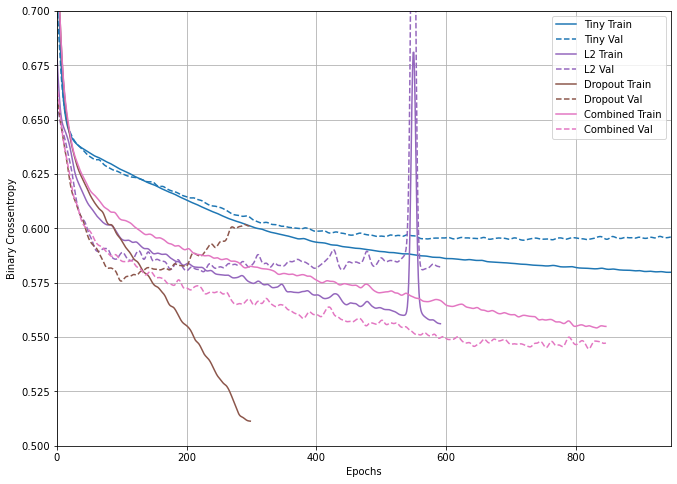

In [21]:
combined_model = tf.keras.Sequential([
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu', input_shape=(FEATURES,)),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(1)
])

regularizer_histories['combined'] = compile_and_fit(combined_model, "regularizers/combined")
plt.figure(figsize=(11,8))
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

In [22]:
# MIT License
#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.
